In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import pypomp
#import seaborn as sns
from plotnine import ggplot, geom_line, aes, facet_wrap, coord_cartesian, geom_point

In [2]:
def funky_transform(lst):
    """Transform rho to perturbation scale"""
    out = [np.log((1 + x)/(1 - x)) for x in lst]
    return out

### Notes about pkl structure:

- Dictionary with two entries
    - fit_out: A list containing output of the fitting step. Each entry is a replicate from the fitting step.
        - Various entries: A tuple of length 2 containing information for a replicate.
            - Entry 0: A JAX array containing the iterated filtering estimate of the log likelihood for each iteration (plus an extra? check when the extra is added)
            - Entry 1: A JAX array containing parameters from particles. First dimension varies iteration, second varies the particle, and the third varies the parameter.
    - pf_out: A list containing the output of the particle filtering step. 
        - Various entries: A list for a different replicate from the particle filtering step.
            - Entry 0: A numpy.float32 representing the estimated log likelihood.
            - Entry 1: A numpy.float32 representing the estimated standard deviation of the LL estimate.


In [14]:
PKL_PATH = "C:/Users/ravis/OneDrive/Documents/danny_honors_thesis/src/1d_global_out.pkl"
pkl_in = pickle.load(open(PKL_PATH, "rb"))

### Final LL estimates:

In [15]:
pd.DataFrame({
    "LL": [x[0] for x in pkl_in["pf_out"]],
    "sd": [x[1] for x in pkl_in["pf_out"]]
}).sort_values(by = "LL")

,LL,sd
7,-1.175689e+04,2.451748
18,-1.174411e+04,1.235810
3,-1.170833e+04,3.169826
14,-1.167116e+04,3.563660
6,2.385441e+26,0.000000
2,9.839649e+30,0.000000
0,NaN,NaN
1,NaN,NaN
4,NaN,NaN
5,NaN,NaN


### Plot traces

In [16]:

traces = pd.DataFrame()
for rep in range(len(pkl_in["fit_out"])):
    for iter in range(pkl_in["fit_out"][rep][1].shape[0]):
        for param in range(pkl_in["fit_out"][rep][1].shape[2]):
            param_avg = float(np.mean(pkl_in["fit_out"][rep][1][iter,:,param]))
            traces = pd.concat([
                traces, 
                pd.DataFrame({
                    "rep":str(rep), 
                    "iter":iter, 
                    "param_index": param,
                    "param_value":param_avg
                }, index = [0])
            ], ignore_index = True)

for rep in range(len(pkl_in["fit_out"])):
    for iter in range(pkl_in["fit_out"][rep][0].size):
        traces = pd.concat([
                traces, 
                pd.DataFrame({
                    "rep":str(rep), 
                    "iter":iter, 
                    "param_index": -1,
                    "param_value":-float(pkl_in["fit_out"][rep][0][iter])
                }, index = [0])
            ], ignore_index = True)
traces

,rep,iter,param_index,param_value
0,0,0,0,-10.313437
1,0,0,1,-8.138431
2,0,0,2,-8.941198
3,0,0,3,-5.753034
4,0,0,4,1.832070
...,...,...,...,...
14135,19,96,-1,NaN
14136,19,97,-1,NaN
14137,19,98,-1,NaN
14138,19,99,-1,NaN


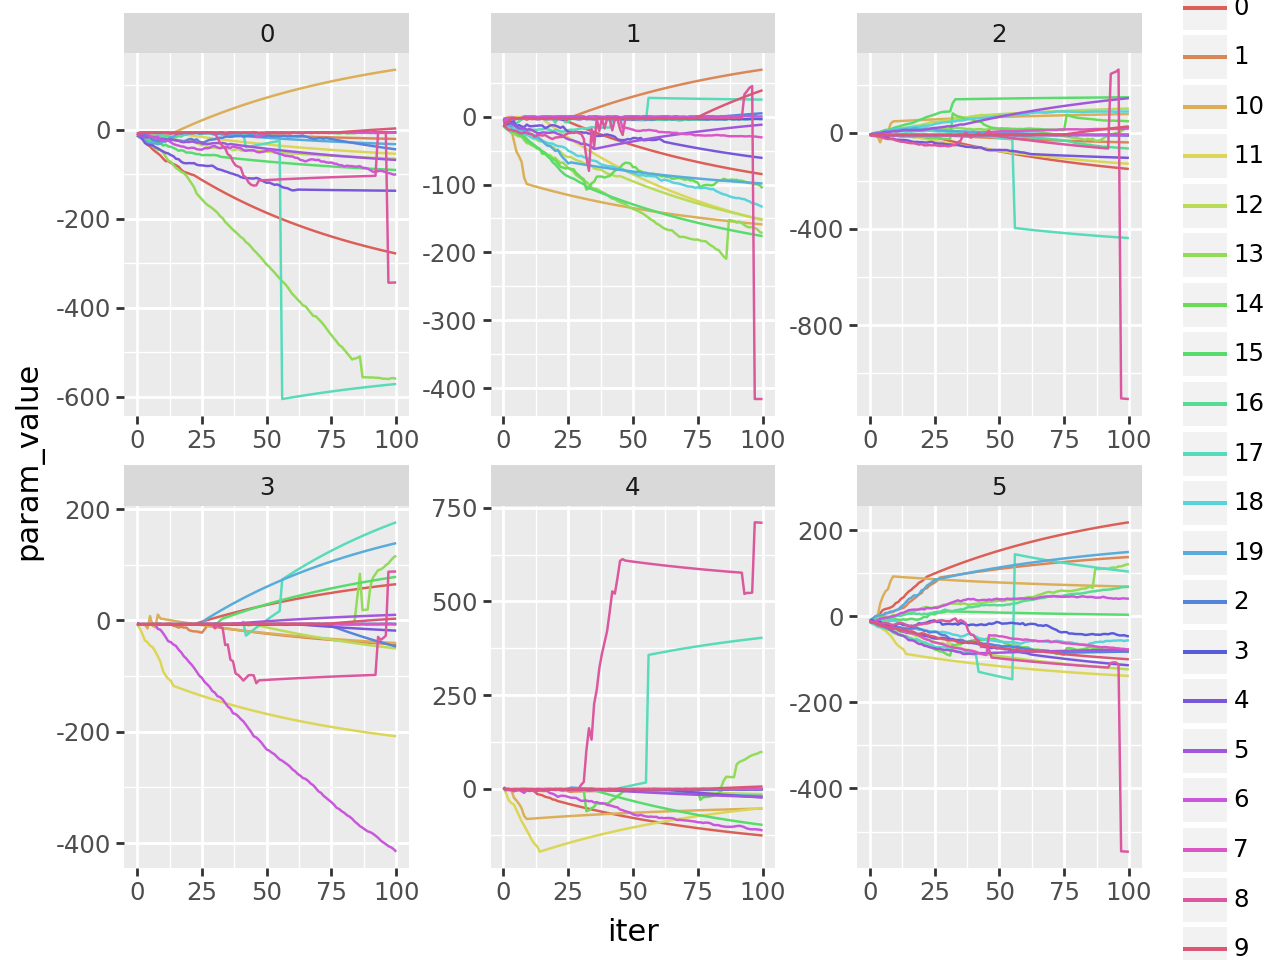

In [17]:
(
    ggplot(
        traces.loc[traces["param_index"] != -1], 
        aes(x = "iter", y = "param_value", group = "rep", color = "rep")
    ) 
    + geom_line()
    + facet_wrap("param_index", scales = "free")
    #+ coord_cartesian(ylim = (0, 5))
)

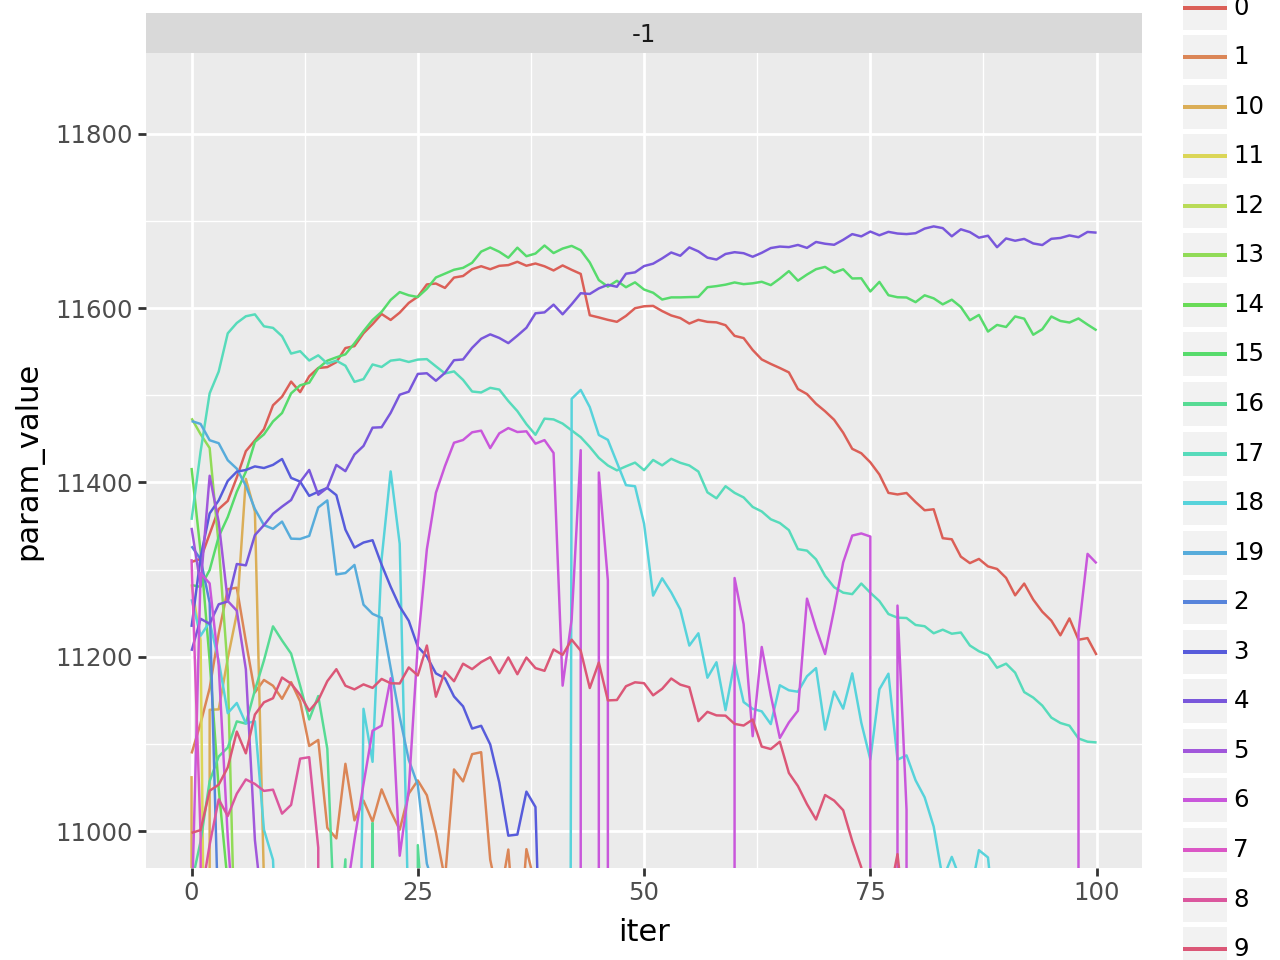

In [13]:
(
    ggplot(
        traces.loc[traces["param_index"] == -1], 
        aes(x = "iter", y = "param_value", group = "rep", color = "rep")
    ) 
    + geom_line()
    + facet_wrap("param_index", scales = "free")
    + coord_cartesian(ylim = (11000, 11850))
)

In [8]:
traces_wide = traces.loc[traces["iter"] == 200].pivot(
    index = "rep", columns = "param_index", values = "param_value"
)
traces_wide.columns = ["-1", "0", "1", "2", "3", "4", "5"]
(
    ggplot(
        traces_wide, 
        aes(x = "3", y = "-1")
    ) 
    + geom_point()
    + coord_cartesian(ylim = (-70000, 11850))
)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 7 elements

In [ ]:
# Weizhe values
print("mu: " + str(np.log(3.68e-4)))
print("kappa: " + str(np.log(3.14e-2)))
print("theta: " + str(np.log(1.12e-4)))
print("xi: " + str(np.log(2.27e-3)))
print("rho: " + str(funky_transform([-7.38e-1])))
print("v0: " + str(np.log(7.66e-3**2)))
# Exact is 11847.12 from profiling in Weizhe's thesis

# Evaluating the Weizhe model with the Weizhe parameters under 
# output/1d_global/weizhe_eval yielded LL 11849.65, sd 1.1217372.

mu: -7.907427619795343
kappa: -3.4609473860679296
theta: -9.09701168666918
xi: -6.087975447488826
rho: [np.float64(-1.8921458020642405)]
v0: -9.743486590459273
